# Supervisor Multi-Agent

In [4]:
import dotenv
import os

dotenv.load_dotenv()
tavily_key = os.getenv("TAVILY_API_KEY")

In [5]:
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)
web_search_results = web_search.invoke("who is the mayor of NYC?")

print(web_search_results["results"][0]["content"])

Mayor Eric Adams has served the people of New York City as an NYPD officer, State Senator, Brooklyn Borough President, and now as the 110th Mayor of the City of New York. Mayor Eric Adams has served the people of New York City as an NYPD officer, State Senator, Brooklyn Borough President, and now as the 110th Mayor of the City of New York. In Albany, Eric built winning coalitions to advance New York City’s values and goals, helping to push through measures to protect tenants and workers, combat gun violence, end the NYPD’s abuses of stop and frisk, and advance human rights — including marriage equality. NYC is a trademark and service mark of the City of New York.


### Research Agent

In [6]:
from langgraph.prebuilt import create_react_agent
from langchain_ollama import ChatOllama

llama = ChatOllama(
    model = "llama3.2:1b",
    temperature=0.1
)

research_agent = create_react_agent(
    model=llama,
    tools=[web_search],
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="research_agent",
)

In [7]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [8]:
for chunk in research_agent.stream(
    {"messages": [{"role": "user", "content": "who is the mayor of NYC?"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  tavily_search (e20f569f-27e4-46c3-9929-00d6b2020a60)
 Call ID: e20f569f-27e4-46c3-9929-00d6b2020a60
  Args:
    query: mayor of NYC


Update from node tools:


================================= Tool Message =================================
Name: tavily_search

{"query": "mayor of NYC", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.nyc.gov/office-of-the-mayor/bio.page", "title": "Office of the Mayor | Mayor's Bio | City of New York - NYC.gov", "content": "Mayor Eric Adams has served the people of New York City as an NYPD officer, State Senator, Brooklyn Borough President, and now as the 110th Mayor of the City of New York. Mayor Eric Adams has served the people of New York City as an NYPD officer, State Senator, Brooklyn Borough President, and now as the 110th Mayor of the City of New York. In Albany,

### Math Agent

In [20]:
def add(a: float, b: float):
    """Add two numbers."""
    return a + b


def multiply(a: float, b: float):
    """Multiply two numbers."""
    return a * b


def divide(a: float, b: float):
    """Divide two numbers."""
    return a / b


math_agent = create_react_agent(
    model=llama,
    tools=[add, multiply, divide],
    prompt=(
        "You are a math agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with math-related tasks\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="math_agent",
)

In [24]:
for chunk in math_agent.stream(
    {"messages": [{"role": "user", "content": "[ ( 3 + 5 ) * 7 ]"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  multiply (7cb0f813-93c3-4c75-9a7a-829dac6c1f69)
 Call ID: 7cb0f813-93c3-4c75-9a7a-829dac6c1f69
  Args:
    a: 8
    b: 2


Update from node tools:


================================= Tool Message =================================
Name: multiply

16.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent

Supervisor response: The result of the calculation is 16.0.




### Supervisor

In [30]:
llama.name = "llama-small"

In [33]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model=init_chat_model(model_provider = "ollama", model="llama3.2:1b"),
    agents=[research_agent, math_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()

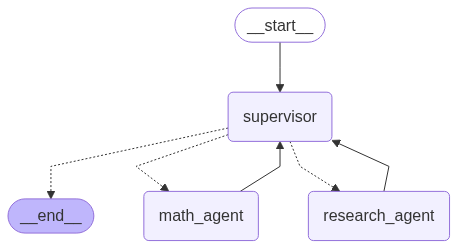

In [35]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png(max_retries=5, retry_delay=30.0 )))

In [43]:
supervisor.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "find US and New York state GDP in 2024. what % of US GDP was New York state?",
            }
        ]
    },
)

{'messages': [HumanMessage(content='find US and New York state GDP in 2024. what % of US GDP was New York state?', additional_kwargs={}, response_metadata={}, id='350ec181-3bfc-46eb-afc4-0eeb900f1600'),
  AIMessage(content='', additional_kwargs={}, response_metadata={}, name='supervisor', id='f7f48d22-0881-4dd5-9c9f-136560c85bad', tool_calls=[{'name': 'transfer_to_math_agent', 'args': {}, 'id': '90f932dd-1776-49ba-9910-64a1cc8fe197', 'type': 'tool_call'}]),
  ToolMessage(content='Successfully transferred to math_agent', name='transfer_to_math_agent', id='889cfe30-1455-4c45-b1f3-0f08025ed473', tool_call_id='90f932dd-1776-49ba-9910-64a1cc8fe197'),
  AIMessage(content="Based on the latest available data, the Gross Domestic Product (GDP) of the United States in 2024 is approximately $25.3 trillion.\n\nThe GDP of New York State in 2024 is estimated to be around $1.2 trillion.\n\nTo calculate the percentage of US GDP that New York state represents, we can use the following formula:\n\n(US GD

> Bad performance because small model